In [1]:
import numpy as np
np.set_printoptions(suppress=True, linewidth=280)
from numba import jit
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
from typing import List, Dict
from recstate import C_, mu_, Sigma_, dC_, dmu_, dSigma_, RG, new_state, G_matrix

%load_ext autoreload
%autoreload 2

In [47]:
@jit(nopython = True)
def approx_new_state(gamma, phi, z, old_state, order = None):
    """
    Constructs the transformed state recursively and exactly
    up to the Nth Fock amplitude, indicated by the keyword argument `order`.
    """
    C = C_(gamma, phi, z)
    mu = mu_(gamma, phi, z)
    Sigma = Sigma_(gamma, phi, z)
    
    cutoff = old_state.shape[0]
    dtype = old_state.dtype
    sqrt = np.sqrt(np.arange(cutoff, dtype=dtype))
    if order is None:
        order = cutoff
    
    R = np.zeros((cutoff, cutoff), dtype=dtype)
    G = np.zeros(cutoff, dtype=dtype)
    
    # first row of Transformation matrix
    G[0] = C
    for n in range(1, cutoff):
        G[n] = mu[1]/sqrt[n]*G[n-1] - Sigma[1,1]*sqrt[n-1]/sqrt[n]*G[n-2]
    
    # first row of R matrix
    for n in range(order):
        R[0, n] = np.dot(G[:cutoff - n], old_state)
        old_state = old_state[1:]*sqrt[1:cutoff-n]

    # rest of R matrix
    for m in range(1, cutoff):
        for n in range(max(1, order-m)): 
            R[m, n] = mu[0]/sqrt[m]*R[m-1, n] - Sigma[0,0]*sqrt[m-1]/sqrt[m]*R[m-2, n] - Sigma[0,1]/sqrt[m]*R[m-1, n+1]
            
    return R[:, 0]

In [48]:
state = np.random.rand(100) + 1.0j*np.random.rand(100)
state /= np.linalg.norm(state)

In [52]:
approx_state(0.1+0.1j, 0.1, 0.1-0.1j, state, order=10)[:10] - new_state(0.1+0.1j, 0.1, 0.1-0.1j, state)[:10]

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [38]:
%timeit approx_state(0.1+0.1j, 0.1, 0.1-0.1j, state, order=11)

15.7 µs ± 160 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [42]:
%timeit new_state(0.1+0.1j, 0.1, 0.1-0.1j, state)

6.48 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
@jit(nopython = True)
def grad_state(gamma, phi, zeta, old_state):
    """
    Gradient of the new state
    """
    
    C = C_(gamma, phi, zeta)
    dC = dC_(gamma, phi, zeta)
    mu = mu_(gamma, phi, zeta)
    dmu = dmu_(gamma, phi, zeta)
    Sigma = Sigma_(gamma, phi, zeta)
    dSigma = dSigma_(gamma, phi, zeta)
    
    R, G = RG(C, mu, Sigma, old_state)
    
    cutoff = len(old_state)
    dtype = old_state.dtype
    sqrt = np.sqrt(np.arange(cutoff, dtype=dtype))
    if order is None:
        order = cutoff
    
    dR = np.zeros((cutoff, cutoff, 5), dtype=dtype)
    dG = np.zeros((cutoff, 5), dtype=dtype)
    
    # grad of first row of Transformation matrix
    dG[0] = dC
    for n in range(cutoff-1):
        dG[n+1] = (dmu[1]*G[n] + mu[1]*dG[n] - dSigma[1,1]*sqrt[n]*G[n-1] - Sigma[1,1]*sqrt[n]*dG[n-1])/sqrt[n+1]
    
    # first row of dR matrix
    for n in range(cutoff):
        dR[0, n] = np.dot(np.transpose(dG[:cutoff - n]), old_state)
        old_state = old_state[1:]*sqrt[1:cutoff-n]

    # rest of dR matrix
    for m in range(cutoff - 1):
        for k in range(cutoff - m - 1):
            dR[m+1, k] = (dmu[0]*R[m, k] + mu[0]*dR[m, k] - dSigma[0,0]*sqrt[m]*R[m-1, k] - Sigma[0,0]*sqrt[m]*dR[m-1, k] - Sigma[0,1]*dR[m, k+1] - dSigma[0,1]*R[m, k+1])/sqrt[m+1]
            
    return np.transpose(dR[:,0])

In [3]:
@tf.custom_gradient
def Ggate(gamma, phi, zeta, Psi):
    """
    Direct evolution of a quantum state
    """
    gamma = gamma.numpy()
    phi = phi.numpy()
    zeta = zeta.numpy()
    Psi = Psi.numpy()
    cutoff = Psi.shape[0]
    
    Psi_new = new_state(gamma, phi, zeta, Psi)
    
    def grad(dy):
        "Vector-Jacobian products for all the arguments"
        dPsi = grad_state(gamma, phi, zeta, Psi) # gradients wrt g,g*,phi,z,z* 
        grad_gamma = tf.reduce_sum(dy*np.conj(dPsi[0]) + tf.math.conj(dy)*dPsi[1])
        grad_phi = 2*tf.math.real(tf.reduce_sum(dy*np.conj(dPsi[2])))
        grad_zeta = tf.reduce_sum(dy*np.conj(dPsi[3]) + tf.math.conj(dy)*dPsi[4])
        grad_Psi = tf.linalg.matvec(G_matrix(gamma, phi, zeta, cutoff), dy, adjoint_a=True)
        
        return grad_gamma, grad_phi, grad_zeta, grad_Psi
    
    return Psi_new, grad

In [5]:
%%timeit
state = np.ones(100, dtype=np.complex128)
for i in range(35):
    state1 = grad_state(0.1+0.0j, 0.1, 0.1+0.1j, state)

53.9 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%timeit 
gamma, phi, zeta = 0.1+0.0j, 0.1, 0.1+0.1j
old_state = np.ones(100, dtype=np.complex128)
C = C_(gamma, phi, zeta)
dC = dC_(gamma, phi, zeta)
mu = mu_(gamma, phi, zeta)
dmu = dmu_(gamma, phi, zeta)
Sigma = Sigma_(gamma, phi, zeta)
dSigma = dSigma_(gamma, phi, zeta)
    
R, G = RG(C, mu, Sigma, old_state)

176 µs ± 62.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
def kerr(k, cutoff):
    diag = tf.exp(1j*tf.cast(k, dtype=tf.complex128)*np.arange(cutoff)**2)
    return diag

In [5]:
def Layer(gamma, phi, zeta, k, state_in):
    state_out = Ggate(gamma, phi, zeta, state_in)
    return kerr(k, len(state_in))*state_out

def init_complex(layers, scale=0.01):
    return np.random.normal(scale=scale, size=layers) + 1j*np.random.normal(scale=scale, size=layers)

def init_real(layers, scale=0.01):
    return np.random.normal(scale=scale, size=layers)

def loss(state, objective):
    return 1.0 - tf.abs(tf.reduce_sum(state*tf.math.conj(objective)))# + tf.reduce_sum([tf.math.abs(v) for v in variables])

def Fidelity(state, objective):
    return tf.abs(tf.reduce_sum(state*tf.math.conj(objective)))**2

In [6]:
from dataclasses import dataclass

@dataclass
class Variables:
    gamma: tf.Variable
    phi: tf.Tensor
    zeta: tf.Variable
    kappa: tf.Variable
    
    @property
    def learnable(self):
        return [self.gamma, self.zeta, self.kappa]
    
    @property
    def all(self):
        return [self.gamma, self.phi, self.zeta, self.kappa]

In [7]:
def Circuit(variables: Variables, state_in: tf.Tensor) -> tf.Tensor:
    gamma, phi, zeta, k = variables.all
    layers = gamma.shape[0]
    cutoff = state_in.shape[0]
    
    state = state_in 
    for i in range(layers):
        state = Layer(variables.gamma[i], variables.phi[i], variables.zeta[i], variables.kappa[i], state)
        
    return state

def circuit_loss() -> tf.float64:
    state_out = Circuit(variables, state_in)
    return loss(state_out, ON)



In [8]:
np.random.seed(137)
tf.random.set_seed(137)

cutoff = 20

LR = 0.001
steps = 2500
layers = 10


state_in = tf.constant(np.eye(cutoff)[0] - np.eye(cutoff)[9], dtype=tf.complex128)/np.sqrt(2)
ON = tf.constant(np.eye(cutoff)[0] + np.eye(cutoff)[9], dtype=tf.complex128)/np.sqrt(2)
PHOTON = tf.constant(np.eye(cutoff)[1], dtype=tf.complex128)

optimizer = tf.optimizers.SGD(LR)

gamma = tf.Variable(init_complex(layers, 0.01), dtype=tf.complex128, name=f'gamma')
phi = tf.constant(init_real(layers), dtype=tf.float64, name=f'phi')
zeta = tf.Variable(init_complex(layers, 0.01), dtype=tf.complex128, name=f'zeta')
kappa = tf.Variable(init_real(layers, 0.01), dtype=tf.float64, name=f'kappa')

variables = Variables(gamma, phi, zeta, kappa)

losses = []

Fidelity: 97.38281%


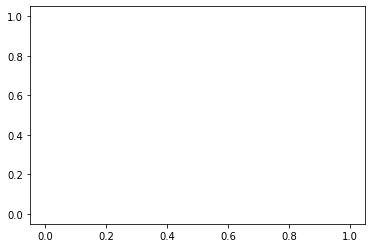

In [9]:
try:
    for _ in tqdm(range(steps)):
#         with tf.GradientTape(persistent=True) as tape:
#             state_out = Circuit(variables, state_in)
#             loss_val = loss(state_out, ON)
        
#         losses.append(loss_val)
        optimizer.minimize(circuit_loss, variables.learnable)
#         dv = tape.gradient(loss_val, learning_variables)
#         optimizer.apply_gradients(zip(dv, learning_variables))
        print(f'Fidelity: {100*(Fidelity(Circuit(variables,state_in), ON).numpy()):.5f}%', end='\r')

except KeyboardInterrupt:
    pass

finally:
    plt.plot(losses[10:])

In [ ]:
try:
    for _ in tqdm(range(steps)):
#         with tf.GradientTape(persistent=True) as tape:
#             state_out = Circuit(variables, state_in)
#             loss_val = loss(state_out, ON)
        
#         losses.append(loss_val)
        optimizer.minimize(circuit_loss, variables.learnable)
#         dv = tape.gradient(loss_val, learning_variables)
#         optimizer.apply_gradients(zip(dv, learning_variables))
        print(f'Fidelity: {100*(Fidelity(Circuit(variables,state_in), ON).numpy()):.5f}%', end='\r')

except KeyboardInterrupt:
    pass

finally:
    plt.plot(losses[10:])

# Scrapbook

In [1]:
from jax import numpy as jnp
from jax import grad

In [2]:
def C_jax(gamma, phi, z):
    r = jnp.abs(z)
    delta = jnp.angle(z)
    return jnp.exp(-0.5*jnp.abs(gamma)**2 - 0.5*jnp.conj(gamma)**2*jnp.exp(1j*(2*phi+delta))*jnp.tanh(r))/jnp.sqrt(jnp.cosh(r))

def C_jax(gamma_r, gamma_phi, phi, r, delta):
    return jnp.exp(-0.5*gamma_r**2 - 0.5*gamma_r**2*jnp.exp(-2j*gamma_phi)*jnp.exp(1j*(2*phi+delta))*jnp.tanh(r))/jnp.sqrt(jnp.cosh(r))

In [ ]:
def example(x, y, z, r, delta):
    return jnp.exp(-0.5*gamma_r**2 - 0.5*gamma_r**2*jnp.exp(-2j*gamma_phi)*jnp.exp(1j*(2*phi+delta))*jnp.tanh(r))/jnp.sqrt(jnp.cosh(r))

In [3]:
grad(C_jax, argnums=2, holomorphic=True)(0.1, 0.1, 0.2, 0.1, 0.1)

/Users/filippo/.pyenv/versions/3.7.3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray(0.00029206, dtype=float32)

In [101]:
dC_(0.1*np.exp(0.1j), 0.2, 0.1*np.exp(0.1j))

array([-0.04935445+0.0049593j , -0.05846361-0.00879386j,  0.00029206-0.00094465j, -0.05884929+0.0029864j , -0.04916183-0.00491558j])

In [7]:
from jax import numpy as np
from numpy import exp

In [8]:
mu_(0.1+0.0j, 0.1, 0.1+0.1j)

DeviceArray([ 0.10776229+0.0117094j , -0.09851364-0.00988433j], dtype=complex64)

In [9]:
from jax import grad, jacfwd

In [10]:
jacfwd(mu_, argnums=2)(0.1, 0.1, 0.1)

DeviceArray([0.09703309+0.01966958j, 0.00986763+0.00099007j], dtype=complex64)

In [8]:
dSigma_(0.0+0.0j, 0.1, 0.1*exp(0.1j))

array([[[ 0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ]],

       [[ 0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ]],

       [[-0.05890781+0.19043294j,  0.09933632-0.99004979j],
        [ 0.09933632-0.99004979j,  0.        +0.j        ]],

       [[ 0.94584645+0.29258459j,  0.09867628+0.00990065j],
        [ 0.09867628+0.00990065j, -0.98512008+0.0988417j ]],

       [[-0.02945391+0.09521647j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.0099502 +0.09917007j]]])

# Recursive loops

In [215]:
def recursive_loop(cutoff, n, indices=[]):
    if n >= 1:
        for k in range(int(n==1), cutoff):
            recursive_loop(cutoff, n - 1, indices+[k])
    else:
        i = len(indices)
        E = list(np.identity(i))
        Psi[tuple(np.array(indices)+E[i])] = (mu[i]*Psi[tuple(indices)] - np.sum([Sigma[i, l]*sqrt[indices[l]]*Psi[tuple(np.array(indices)-E(l))] for l in range(i)]))/sqrt[indices[i]+1]

In [40]:
def e(size, n):
    z = np.zeros(size, dtype=np.int32)
    z[n] = 1
    return z


def Gaussian_state(C, mu, Sigma, cutoff, dtype=np.complex128):
    
    sqrt = np.sqrt(np.arange(cutoff, dtype=dtype))
    modes = len(mu)//2
    
    Psi = np.zeros([cutoff]*modes, dtype=dtype)
    Psi[tuple(np.zeros(modes, dtype=np.int32))] = C
    
    for i in range(modes):
        for indices in product(range(cutoff), repeat=i):
            for last_index in range(cutoff-1):
                k_plus1 = list(indices)+[last_index+1]
                k = list(indices)+[last_index]
                Psi[tuple(k_plus1)] = (mu[i]*Psi[tuple(k)] - np.sum([Sigma[i, l]*sqrt[k[l]]*Psi[tuple(np.array(k)-e(i+1,l))] for l in range(i+1)]))/sqrt[k_plus1[-1]]
#                 Psi[tuple(k_plus1)] = (mu[i]*Psi[tuple(k)] - np.sum(Sigma[i, np.arange(i+1)]*sqrt[np.array(k)]*Psi[np.array(k_plus1)-np.identity(i+1, dtype=np.int32)]))/sqrt[k_plus1[-1]]
    
    return Psi



@jit(nopython=True)
def fill_rank(cutoff:int, Psi:np.array, mu:np.array, Sigma:np.array, sqrt:np.array, n:int, indices=np.array([], dtype=np.int32))->None:
    if n >= 1:
        for k in range(cutoff - int(n==1)):
            fill_rank(cutoff, Psi, mu, Sigma, sqrt, n - 1, np.concatenate([indices, np.array([k])]))
    else:
        i = len(indices)
        E = list(np.identity(i))
        Psi[tuple(np.array(indices)+E[-1])] = (mu[i-1]*Psi[tuple(indices)] - np.sum([Sigma[i, l]*sqrt[indices[l]]*Psi[tuple(np.array(indices)-E[l])] for l in range(i)]))/sqrt[indices[-1]+1]

@jit(nopython=True)
def Gaussian_state(C, mu, Sigma, cutoff, tup, dtype=np.complex128):
    
    sqrt = np.sqrt(np.arange(cutoff, dtype=dtype))
    modes = len(mu)//2
    
    Psi = np.zeros(tup, dtype=dtype)
    Psi[tup] = C
    
    for i in range(1,modes+1):
        fill_rank(cutoff, Psi, mu, Sigma, sqrt, i)
    
    return Psi

In [41]:
def Gaussian_state_helper(C, mu, Sigma, cutoff, dtype=np.complex128):
    modes = len(mu)//2
    tup = tuple([cutoff]*modes)
    return Gaussian_state(C, mu, Sigma, cutoff, tup, dtype=np.complex128)

In [42]:
Gaussian_state_helper(C(0.1, 0.1, 0.1), mu(0.1, 0.1, 0.1), Sigma(0.1 ,0.1, 0.1), 10)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of Function(<class 'tuple'>) with argument(s) of type(s): (array(int32, 1d, C))
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: resolving callee type: Function(<class 'tuple'>)[0m
[0m[1m[2] During: typing of call at <ipython-input-40-a511982c04d6> (35)
[0m
[1m
File "<ipython-input-40-a511982c04d6>", line 35:[0m
[1mdef fill_rank(cutoff:int, Psi:np.array, mu:np.array, Sigma:np.array, sqrt:np.array, n:int, indices=np.array([], dtype=np.int32))->None:
    <source elided>
        E = list(np.identity(i))
[1m        Psi[tuple(np.array(indices)+E[-1])] = (mu[i-1]*Psi[tuple(indices)] - np.sum([Sigma[i, l]*sqrt[indices[l]]*Psi[tuple(np.array(indices)-E[l])] for l in range(i)]))/sqrt[indices[-1]+1]
[0m        [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function fill_rank at 0x1214d6d08>))[0m
[0m[1m[2] During: typing of call at <ipython-input-40-a511982c04d6> (47)
[0m
[0m[1m[3] During: resolving callee type: type(CPUDispatcher(<function fill_rank at 0x1214d6d08>))[0m
[0m[1m[4] During: typing of call at <ipython-input-40-a511982c04d6> (47)
[0m
[1m
File "<ipython-input-40-a511982c04d6>", line 47:[0m
[1mdef Gaussian_state(C, mu, Sigma, cutoff, tup, dtype=np.complex128):
    <source elided>
    for i in range(1,modes+1):
[1m        fill_rank(cutoff, Psi, mu, Sigma, sqrt, i)
[0m        [1m^[0m[0m


In [26]:
test = np.array([], dtype=np.int32)

In [32]:
test1 = np.array([3], dtype=np.int32)

In [34]:
np.concatenate([test, test1])

array([3], dtype=int32)

In [313]:
Ggate(C(0.1, 0.1, 0.1), mu(0.1, 0.1, 0.1), Sigma(0.1 ,0.1, 0.1), 10)[:,0]

array([ 0.99204753-0.00009822j,  0.10889539+0.00195357j, -0.06007369-0.01357917j, -0.01244515-0.00284562j,  0.00416882+0.00201037j,  0.00123979+0.00057141j,
       -0.0002803 -0.00022801j, -0.0001131 -0.00008407j,  0.00001706+0.00002268j,  0.00000946+0.0000107j ])

In [279]:
%timeit Gaussian_state(C(0.1, 0.1, 0.1), mu(0.1, 0.1, 0.1), Sigma(0.1 ,0.1, 0.1), 50)

1.44 ms ± 64.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
e

In [296]:
new_state(0.1, 0.1, 0.1, np.identity(10, dtype=np.complex128)[0])[:,0]

array([ 0.99204753-0.00009822j,  0.10889539+0.00195357j, -0.06007369-0.01357917j, -0.01244515-0.00284562j,  0.00416882+0.00201037j,  0.00123979+0.00057141j,
       -0.0002803 -0.00022801j, -0.0001131 -0.00008407j,  0.00001706+0.00002268j,  0.00000946+0.0000107j ])

In [148]:
mu(0.1, 0.1, 0.1)

array([ 0.10976813+0.0019801j , -0.09900498-0.00993363j])

In [137]:
e(1,1)

asked for e_n (size 1, n 1)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [76]:
Z[tuple([0,0])]

array([0., 0., 0.])